Using device: cuda


/home/bren/anaconda3/envs/rapids-24.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/bren/anaconda3/envs/rapids-24.12/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/bren/anaconda3/envs/rapids-24.12/lib/python3.12/site-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724898583682/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch [10/100], Train Loss: 93301.1385, Val Loss: 44989.7422
Epoch [20/100], Train Loss: 79338.7272, Val Loss: 45102.8008
Epoch [30/100], Train Loss: 76469.1675, Val Loss: 37061.2852
Epoch [40/100], Train Loss: 75265.1742, Val Loss: 46102.0391
Epoch [50/100], Train Loss: 74987.0101, Val Loss: 39011.1875
Epoch [60/100], Train Loss: 75058.5687, Val Loss: 43544.6836
Epoch [70/100], Train Loss: 75074.7060, Val Loss: 47349.2930
Epoch [80/100], Train Loss: 74653.2492, Val Loss: 40141.2109
Epoch [90/100], Train Loss: 74576.7607, Val Loss: 40324.9766
Epoch [100/100], Train Loss: 74217.3611, Val Loss: 39047.5859
Final Test Loss: 39047.5859


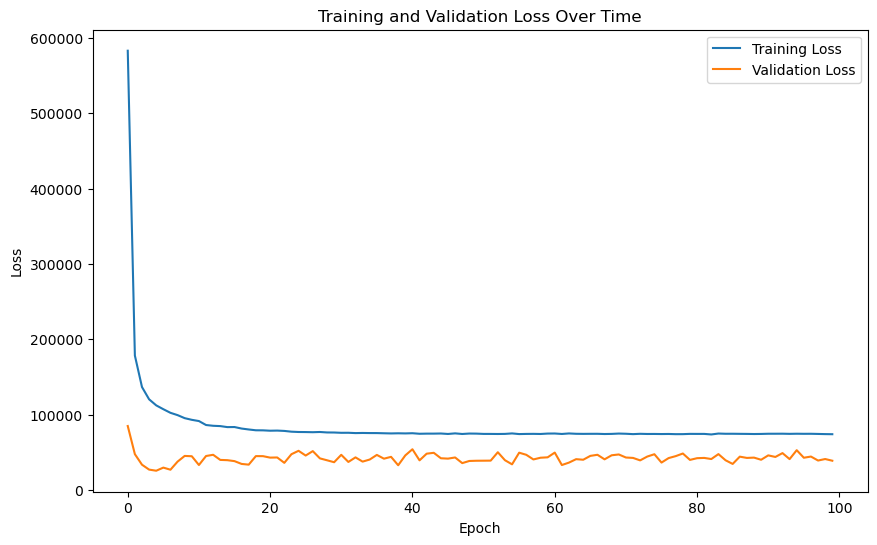

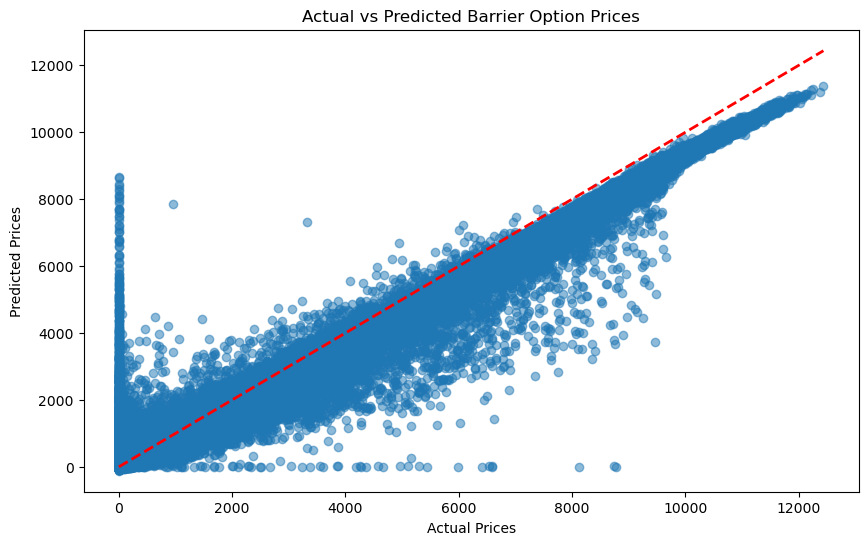

Mean Absolute Error: 92.3355
Root Mean Squared Error: 197.6046
R-squared Score: 0.9928


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BarrierOptionModel(nn.Module):
    def __init__(self, input_dim):
        super(BarrierOptionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def train_model():
    # Load data
    file_path = 'barriers_v2_10M.zip'
    data = pd.read_csv(file_path, compression='zip')
    
    # Separate features and target
    X = data.drop('Price', axis=1)
    y = data['Price']
    
    # Identify numeric and categorical columns
    numeric_features = ['Strike', 'Barrier', 'Maturity', 'Spot', 'Rate', 'Volatility']
    categorical_features = ['BarrierType', 'ExerciseType', 'OptionType']

    # Create preprocessing steps
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit the preprocessor and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    
    # Initialize the model
    input_dim = X_train.shape[1]
    #model = BarrierOptionModel(input_dim=input_dim).to(device)

    # Wrap the model with DataParallel
    model = BarrierOptionModel(input_dim=input_dim)
    model = torch.nn.DataParallel(model).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    
    # Training loop
    num_epochs = 100
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test_tensor)
            val_loss = criterion(val_predictions, y_test_tensor).item()
            val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        print(f'Final Test Loss: {test_loss.item():.4f}')
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions.cpu().numpy(), alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Barrier Option Prices')
    plt.show()
    
    # Calculate and print error metrics
    test_predictions_np = test_predictions.cpu().numpy()
    mae = mean_absolute_error(y_test, test_predictions_np)
    mse = mean_squared_error(y_test, test_predictions_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, test_predictions_np)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'R-squared Score: {r2:.4f}')

if __name__ == "__main__":
    train_model()